Dataset  → 6376 images  |  feat-dim = 512
 Best CV 5-fold F1 = 0.885  |  C = 10

TRAIN metrics
F1     : 0.8889299574939937
Acc    : 0.8821568627450981
Prec   : 0.8920623145400594
Recall : 0.8858195211786372
ROC-AUC: 0.9491723517534004


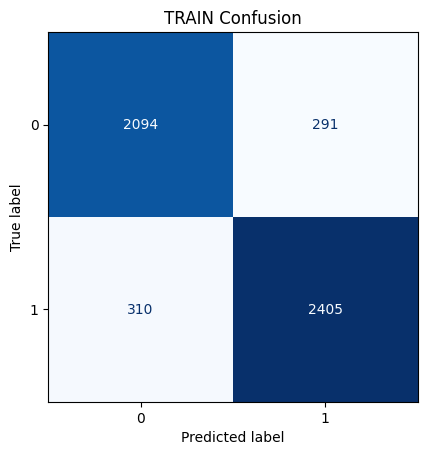

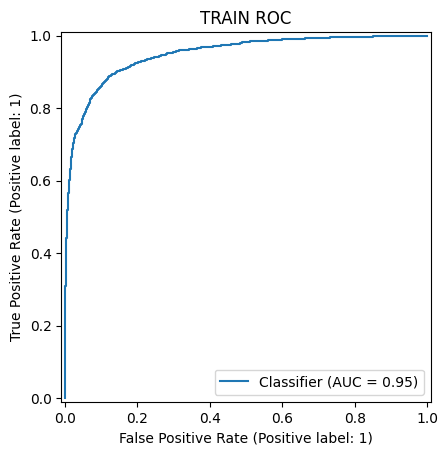


VAL metrics
F1     : 0.8764044943820225
Acc    : 0.8706896551724138
Prec   : 0.8917682926829268
Recall : 0.8615611192930781
ROC-AUC: 0.9462062398393539


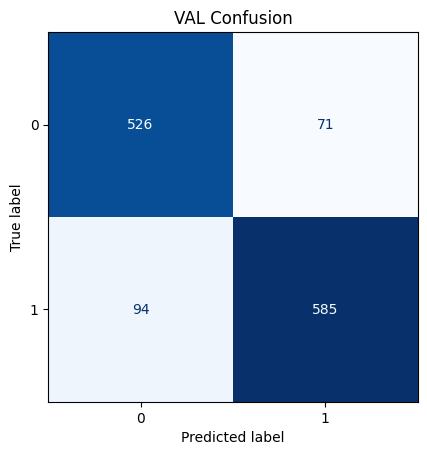

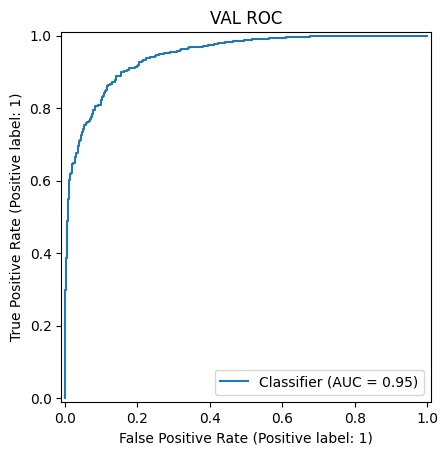


 Saved submission_logreg_binary.csv rows: 500


In [15]:
# ================================================================
#  Pre-trained ResNet18  ➜  Logistic Regression (pleasant=1, unpleasant=0)
# ================================================================
import itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch, torchvision.transforms as T, torchvision.models as models

from sklearn.preprocessing   import StandardScaler
from sklearn.decomposition   import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import (f1_score, accuracy_score, precision_score,
                                     recall_score, roc_auc_score,
                                     ConfusionMatrixDisplay, RocCurveDisplay)

# ------------------- 0. Paths & Device -------------------------
# Define paths to training images, test images, and ID CSV
train_dir    = Path(r"C:\Users\gkara\Desktop\5th year\summer\mihaniki mathisi\train-images\train")
test_img_dir = Path(r"C:\Users\gkara\Desktop\5th year\summer\mihaniki mathisi\TEST_images\TEST_images")
ids_csv      = Path(r"C:\Users\gkara\Desktop\5th year\summer\mihaniki mathisi\Test-IDs.csv")

# Select GPU if available, otherwise use CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- 1. ResNet‑18 feature extractor ----------------
# Load pretrained ResNet-18 and remove final classification layer
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
feat_extractor = torch.nn.Sequential(*(list(resnet.children())[:-1]))
feat_extractor.eval().to(DEVICE)

# Define image transforms: resize, normalize, convert to 3 channels
img_tf = T.Compose([
    T.Resize((224, 224)),                 # Resize to 224x224 as expected by ResNet
    T.ToTensor(),                         # Convert PIL image to tensor [0,1]
    T.Lambda(lambda x: x.repeat(3, 1, 1)),# Repeat grayscale channel to create 3 channels
    T.Normalize([0.485, 0.456, 0.406],    # Normalize using ImageNet means
                [0.229, 0.224, 0.225])    # and standard deviations
])

@torch.no_grad()
def img2feat(p: Path) -> np.ndarray:
    """
    Load image, apply transforms, extract 512-dim features with ResNet-18
    """
    img = Image.open(p).convert("L")           # Open image in grayscale
    x = img_tf(img).unsqueeze(0).to(DEVICE)      # Add batch dimension and move to DEVICE
    feats = feat_extractor(x)                    # Extract features
    return feats.squeeze().cpu().numpy()         # Remove extra dims and convert to NumPy

# ---------------- 2. Load features & labels -----------------
# Map class names to integer labels
label_map = {"unpleasant": 0, "pleasant": 1}
X, y = [], []
# Iterate over classes in fixed order to maintain label mapping
for cls in ("unpleasant", "pleasant"):     
    for img in (train_dir/cls).iterdir():         # Extract and collect features
        X.append(img2feat(img)); y.append(label_map[cls])      # Append corresponding label

# Stack feature vectors into array and convert types
X = np.vstack(X).astype("float32")            # Shape: (n_samples, 512)
y = np.array(y,  dtype="int8")                # Shape: (n_samples,)

print(f"Dataset  → {X.shape[0]} images  |  feat-dim = {X.shape[1]}")

# ----------- 3. Train / Validation split ------------------------
# Split data into 80% train and 20% validation with stratification
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42)

# ------------------- 4. Scale & PCA ----------------------------
# Standardize features to zero mean/unit variance
scaler = StandardScaler().fit(X_tr)
X_tr    = scaler.transform(X_tr)
X_val   = scaler.transform(X_val)

pca = PCA(n_components=40, whiten=True, random_state=42).fit(X_tr)
X_tr  = pca.transform(X_tr)
X_val = pca.transform(X_val)

# ------------------- 5. Grid-search Logistic Regression ---------
# Test various regularization strengths C
Cs = [0.01, 0.1, 1, 10, 100]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1, best_C = 0, None
for C in Cs:
    lr = LogisticRegression(C=C, solver="lbfgs", max_iter=500)
    y_cv = cross_val_predict(lr, X_tr, y_tr, cv=cv, method="predict")
    f1   = f1_score(y_tr, y_cv)
    if f1 > best_f1:
        best_f1, best_C = f1, C

print(f" Best CV 5-fold F1 = {best_f1:.3f}  |  C = {best_C}")

# ------------------- 6. Train final Logistic Regression ---------
model = LogisticRegression(C=best_C, solver="lbfgs", max_iter=500)
model.fit(X_tr, y_tr)

# ------------------- 7. TRAIN & VAL metrics --------------------
# Helper to get probability of class "pleasant" (=1)
def get_prob(X):
    return model.predict_proba(X)[:,1]

# Predictions & probabilities
train_pred = model.predict(X_tr)
train_prob = get_prob(X_tr)
val_pred   = model.predict(X_val)
val_prob   = get_prob(X_val)

# Print training metrics
print("\nTRAIN metrics")
print("F1     :", f1_score(y_tr, train_pred))
print("Acc    :", accuracy_score(y_tr, train_pred))
print("Prec   :", precision_score(y_tr, train_pred))
print("Recall :", recall_score(y_tr, train_pred))
print("ROC-AUC:", roc_auc_score(y_tr, train_prob))

# Plot training confusion matrix & ROC
ConfusionMatrixDisplay.from_predictions(y_tr, train_pred, cmap="Blues", colorbar=False)
plt.title("TRAIN Confusion"); plt.show()
RocCurveDisplay.from_predictions(y_tr, train_prob)
plt.title("TRAIN ROC"); plt.show()

# Print validation metrics
print("\nVAL metrics")
print("F1     :", f1_score(y_val, val_pred))
print("Acc    :", accuracy_score(y_val, val_pred))
print("Prec   :", precision_score(y_val, val_pred))
print("Recall :", recall_score(y_val, val_pred))
print("ROC-AUC:", roc_auc_score(y_val, val_prob))

# Plot validation confusion matrix & ROC
ConfusionMatrixDisplay.from_predictions(y_val, val_pred, cmap="Blues", colorbar=False)
plt.title("VAL Confusion"); plt.show()
RocCurveDisplay.from_predictions(y_val, val_prob)
plt.title("VAL ROC"); plt.show()

# ------------------- 8. Test → Hard-label submission -----------
ids_df     = pd.read_csv(ids_csv)  # load test IDs
# Extract features for test set
test_feats = [img2feat(test_img_dir/f) for f in ids_df["Filename"]]
test_feats = scaler.transform(np.vstack(test_feats))
test_feats = pca.transform(test_feats)

# Compute probabilities, threshold at 0.5, convert to 0/1
test_prob = model.predict_proba(test_feats)[:,1]
test_lbl  = (test_prob >= 0.5).astype(int)

# Save submission file
submission = pd.DataFrame({"ID": ids_df["ID"], "LABEL": test_lbl})
submission.to_csv("submission_logreg_binary.csv", index=False)
print(f"\n Saved submission_logreg_binary.csv rows: {len(submission)}")
